# sup6B&C

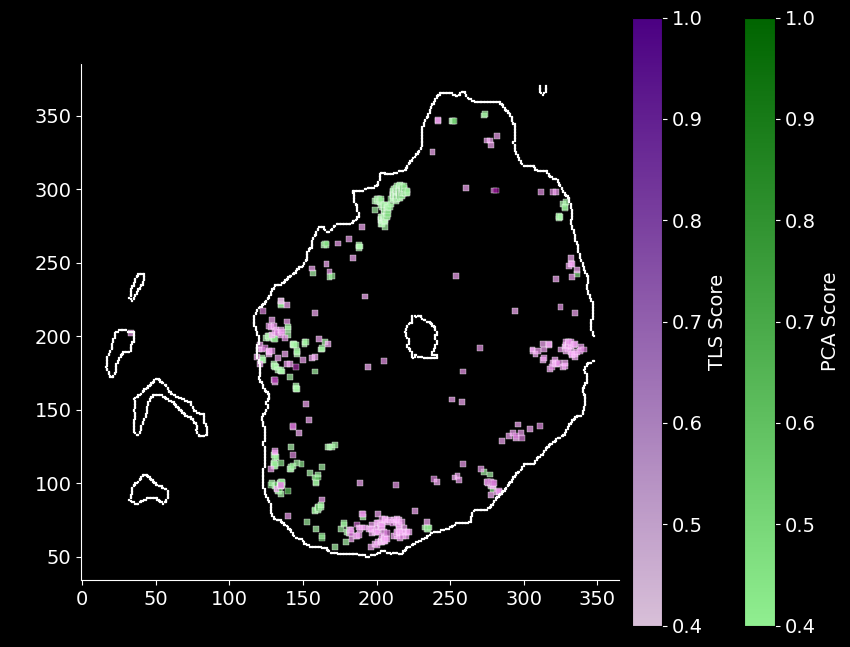

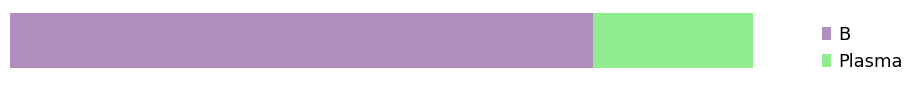

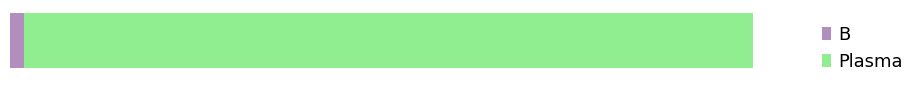

/home/fengyu/miniconda3/envs/st/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


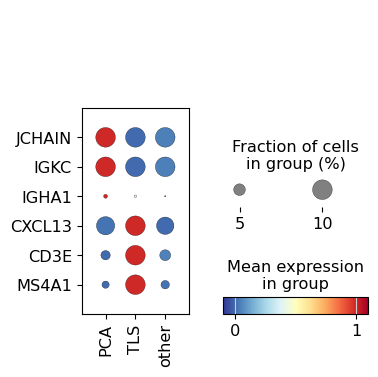

In [3]:
import scanpy as sc
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, Normalize
from matplotlib.cm import ScalarMappable
import seaborn as sns
import os
import diopy

# --- Helper: Consistent vector-friendly plotting ---
def vector(on=False):
    if on:
        sc.set_figure_params(dpi=50, dpi_save=300, vector_friendly=False)
    else:
        sc.set_figure_params(dpi=50, dpi_save=300, vector_friendly=True)
vector(False)

# --- PART 1: Spatial KDE/score plot (nPCA / nTLS) ---
adata = sc.read_h5ad("/data1/zhangyang/Method/Figure3_file/method_h5ad_data/LC_B03425E1_bin50_scanpy_out.h5ad")

# Calculate scores for two modules, normalize [0,1]
sc.tl.score_genes(adata, ['IGKC','IGHG4','IGHG1','IGLC1','IGLC2','IGLC3','IGLC4','IGLC5','IGLC6','IGLC7'], score_name='PCA')
sc.tl.score_genes(adata, ['TRBC1','TRBC2','TRAC','CXCL13','MS4A1','FDCSP','CD3E','CD3D','CD3G'], score_name='TLS')
adata.obs['nPCA'] = (adata.obs['PCA'] - adata.obs['PCA'].min()) / (adata.obs['PCA'].max() - adata.obs['PCA'].min())
adata.obs['nTLS'] = (adata.obs['TLS'] - adata.obs['TLS'].min()) / (adata.obs['TLS'].max() - adata.obs['TLS'].min())

# Prepare pixelized image coordinates
adata.obs['X'] = adata.obs['x'] // 50
adata.obs['Y'] = adata.obs['y'] // 50
df = adata.obs[['X', 'Y']]
max_x, max_y = df['X'].max(), df['Y'].max()
image = np.zeros((max_y + 1, max_x + 1), dtype=np.uint8)
for _, row in df.iterrows():
    image[row['Y'], row['X']] = 255
edges = cv2.Canny(image, 50, 150)
edge_coordinates = np.column_stack(np.where(edges > 0))
df1 = adata.obs[['nPCA', 'nTLS', 'X', 'Y']]
df2 = pd.DataFrame(edge_coordinates, columns=['Y', 'X'])

plt.figure(figsize=(10, 8))
ax = plt.gca()
ax.set_facecolor('black')
ax.figure.patch.set_facecolor('black')
# Greens (PCA)
custom_green = LinearSegmentedColormap.from_list('custom_green', [(0.7, 1.0, 0.7), (0.0, 0.5, 0.0)])
sns.scatterplot(x='X', y='Y', hue='nPCA', palette=custom_green, data=df1[df1['nPCA'] > 0.45],
                marker='s', alpha=0.7, legend=None, size=0.2, ax=ax)
# Purples (TLS)
custom_purple = LinearSegmentedColormap.from_list('custom_purple', [(1.0, 0.7, 1.0), (0.5, 0.0, 0.5)])
sns.scatterplot(x='X', y='Y', hue='nTLS', palette=custom_purple, data=df1[df1['nTLS'] > 0.3],
                marker='s', alpha=0.7, legend=None, size=0.2, ax=ax)
# White tissue border
sns.scatterplot(x='X', y='Y', data=df2, color='white', marker='s', s=3, edgecolor=None, legend=None, ax=ax)
# Axis style
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_color('white')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')
ax.set_aspect('equal')
# Two colorbars
cmap_a = LinearSegmentedColormap.from_list('custom_greens', ['lightgreen', 'darkgreen'])
norm_a = Normalize(vmin=0.4, vmax=df1['nPCA'].max())
sm_a = ScalarMappable(norm=norm_a, cmap=cmap_a)
sm_a.set_array([])
cbar_a = plt.colorbar(sm_a, ax=plt.gca(), orientation='vertical', pad=0.02)
cbar_a.set_label('PCA Score', color='white')
cbar_a.ax.tick_params(colors='white')

cmap_b = LinearSegmentedColormap.from_list('custom_purples', ['thistle', 'indigo'])
norm_b = Normalize(vmin=0.4, vmax=df1['nTLS'].max())
sm_b = ScalarMappable(norm=norm_b, cmap=cmap_b)
sm_b.set_array([])
cbar_b = plt.colorbar(sm_b, ax=plt.gca(), orientation='vertical', pad=0.02)
cbar_b.set_label('TLS Score', color='white')
cbar_b.ax.tick_params(colors='white')
plt.grid(False)
plt.show()

# --- PART 2: Cell type barplots in TLS/PCA regions ---
data1 = pd.read_csv('/data1/zhangyang/Method/Review/RCTD/Result/LC_B03425E1_bin50_RCTD_celltype.csv')
data = diopy.input.read_h5('/data1/fengyu/methods/spRNA/h5_file/LC_B03425E1_bin50_scdata_norm.h5')
data1 = data1.rename(columns={'Unnamed: 0': 'st_barcode'})
data2 = data.obs
data2['st_barcode'] = 'DNB_' + data2['x'].astype(str) + '_' + data2['y'].astype(str)
TLS = data2[data2['TLS'] == 'yes']['st_barcode'].tolist()
PCA = data2[data2['PCA'] == 'yes']['st_barcode'].tolist()
TLS_row = data1[data1['st_barcode'].isin(TLS)]
PCA_row = data1[data1['st_barcode'].isin(PCA)]
# TLS
TLS_B = TLS_row['b_cell'].sum()
TLS_P = TLS_row['plasma_cell'].sum()
TLS_all = TLS_B + TLS_P
fig, ax = plt.subplots(figsize=(10, 0.8))
colors = {'B': '#B18EBE', 'Plasma': '#90EE90'}
bar_height = 0.2
percent_b_cell = (TLS_B / TLS_all) * 100 if TLS_all else 0
percent_plasma_cell = (TLS_P / TLS_all) * 100 if TLS_all else 0
ax.barh(['Cell Types'], [percent_b_cell], height=bar_height, label='B', color=colors['B'])
ax.barh(['Cell Types'], [percent_plasma_cell], height=bar_height, left=[percent_b_cell], label='Plasma', color=colors['Plasma'])
ax.set_xticks([]); ax.set_yticks([])
for spine in ax.spines.values():
    spine.set_visible(False)
ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1), frameon=False)
plt.show()
# PCA
PCA_B = PCA_row['b_cell'].sum()
PCA_P = PCA_row['plasma_cell'].sum()
PCA_all = PCA_B + PCA_P
fig, ax = plt.subplots(figsize=(10, 0.8))
percent_b_cell = (PCA_B / PCA_all) * 100 if PCA_all else 0
percent_plasma_cell = (PCA_P / PCA_all) * 100 if PCA_all else 0
ax.barh(['Cell Types'], [percent_b_cell], height=bar_height, label='B', color=colors['B'])
ax.barh(['Cell Types'], [percent_plasma_cell], height=bar_height, left=[percent_b_cell], label='Plasma', color=colors['Plasma'])
ax.set_xticks([]); ax.set_yticks([])
for spine in ax.spines.values():
    spine.set_visible(False)
ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1), frameon=False)
plt.show()

# --- PART 3: Dotplots by TLS/PCA ---
folder_path = '/data1/fengyu/methods/spRNA/h5_file/'
save_folder = 'TLS&PCA_codotplot'
os.makedirs(save_folder, exist_ok=True) 
norm_h5_files = [f for f in os.listdir(folder_path)
                 if f.endswith('LC_B03425E1_bin50_scdata_norm.h5')]
genels = ['JCHAIN', 'IGKC', 'IGHA1', 'CXCL13', 'CD3E', 'MS4A1']
for fname in norm_h5_files:
    adata = diopy.input.read_h5(os.path.join(folder_path, fname))
    adata.obs['TLSorPCA'] = 'other'
    adata.obs.loc[adata.obs.TLS == 'yes', 'TLSorPCA'] = 'TLS'
    adata.obs.loc[adata.obs.PCA == 'yes', 'TLSorPCA'] = 'PCA'
    filteredgenes = [g for g in genels if g in adata.var_names]
    fig, ax = plt.subplots(figsize=(4, 4))
    sc.pl.dotplot(
        adata,
        filteredgenes,
        groupby='TLSorPCA',
        standard_scale='var',
        show=False,
        dot_max=0.1,
        swap_axes=True,
        color_map='RdYlBu_r',
        ax=ax,
        vmax=1.1,
        vmin=-0.1
    )
    ax.set_xticklabels(ax.get_xticklabels(),
                       rotation=0,
                       ha='center',
                       fontsize=12)
    plt.tight_layout()
    out_path = os.path.join(save_folder, f"{fname.replace('.h5', '')}.pdf")
    plt.savefig(out_path, dpi=600, bbox_inches='tight')
    plt.show(fig)

# sup6D

/home/fengyu/miniconda3/envs/st/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/tmp/ipykernel_855996/989305855.py:17: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['x'] = adata.obs['x'].astype(int)


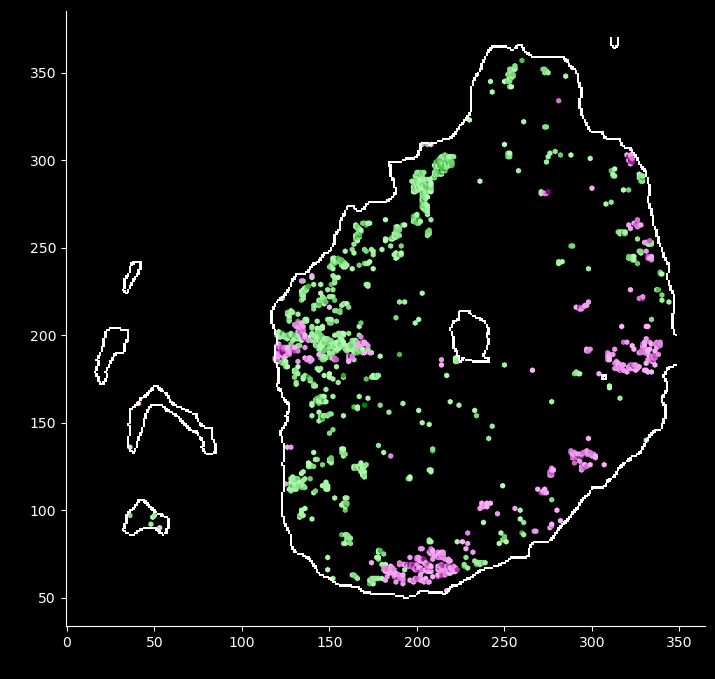

In [1]:
import diopy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from matplotlib.colors import LinearSegmentedColormap

# --- Load and prepare data ---
adata = diopy.input.read_h5(file='/data1/zhangyang/Method/Review/RCTD/Result/LC_B03425E1_bin50_scdata_counts_with_cellweights.h5')

# 1. Remove all rows with any missing values in .obs
valid_indices = adata.obs.dropna().index
adata = adata[valid_indices, :]

# 2. Convert coordinates to bin grid for image/contour
adata.obs['x'] = adata.obs['x'].astype(int)
adata.obs['y'] = adata.obs['y'].astype(int)
adata.obs['X'] = adata.obs['x'] // 50
adata.obs['Y'] = adata.obs['y'] // 50

df = adata.obs[['X', 'Y']]

max_x, max_y = df['X'].max(), df['Y'].max()
image = np.zeros((max_y + 1, max_x + 1), dtype=np.uint8)
for _, row in df.iterrows():
    image[row['Y'], row['X']] = 255
edges = cv2.Canny(image, 50, 150)
edge_coordinates = np.column_stack(np.where(edges > 0))

df1 = adata.obs[['t_cell', 'b_cell', 'plasma_cell', 'X', 'Y']]
df2 = pd.DataFrame(edge_coordinates, columns=['Y', 'X'])

# --- Plotting: plasma (green) and b_cell (purple) ---
plt.figure(figsize=(10, 8))
ax = plt.gca()
ax.set_facecolor('black')
ax.figure.patch.set_facecolor('black')
alpha = 1

# Green colormap for plasma_cell
custom_green_cmap = LinearSegmentedColormap.from_list('custom_green', [(0.7, 1.0, 0.7), (0.0, 0.5, 0.0)])
sns.scatterplot(
    x='X', y='Y', 
    size=0.1, hue='plasma_cell', palette=custom_green_cmap,
    data=df1[df1['plasma_cell'] > 0.3],
    marker='h', edgecolor='none', alpha=alpha, legend=None, ax=ax
)

# Purple colormap for b_cell
custom_purple_cmap = LinearSegmentedColormap.from_list('custom_purple', [(1.0, 0.7, 1.0), (0.5, 0.0, 0.5)])
sns.scatterplot(
    x='X', y='Y', 
    size=0.1, hue='b_cell', palette=custom_purple_cmap,
    data=df1[df1['b_cell'] > 0.1],
    marker='h', edgecolor='none', alpha=alpha, legend=None, ax=ax
)

# --- Overlay tissue edge (white) ---
sns.scatterplot(
    x='X', y='Y', 
    data=df2, color='white',
    marker='s', s=3, edgecolor='none', legend=None, ax=ax
)

# --- Style: axes and aspect ---
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_color('white')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')
ax.set_aspect('equal')

# --- Export image ---
#custom_path = 'LC_B03425E1_bin50_scdata_counts_with_cellweights.png'
#plt.savefig(custom_path, dpi=600, bbox_inches='tight')
plt.show()
plt.close()